In [1]:
##Preable
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

In [2]:
def fillShape(grid,points):
    ##This function takes a list of lists points and returns a grid with the shape bound by said points filled in.
    ##Points in the sublists are connected in the order they are given
    ##Sublists are not connected to each other
    outline = np.zeros([len(grid),len(grid[0])])##Create a grid to plot the outline on
    for i in range(len(points)):##Iterate over the list of point lists
        for j in range(len(points[i])):##Iterate over the points in each sublist
            k = (j + 1)%len(points[i])##Take also the next point, or if the point is the last point, take the first point
            outline[points[i][j][0]][points[i][j][1]] = 1 ##The points are set on the outline grid
            if points[i][j][0] - points[i][k][0] != 0: ##Fill in a line between the points as long as they have different y coordinates
                if points[i][j][0] < points[i][k][0]: ##Make sure x1,y1 is to the left of x2,y2
                    x1 = points[i][j][0]
                    y1 = points[i][j][1]
                    x2 = points[i][k][0]
                    y2 = points[i][k][1]
                else:
                    x1 = points[i][k][0]
                    y1 = points[i][k][1]
                    x2 = points[i][j][0]
                    y2 = points[i][j][1]
                for l in range(x1,x2):##For every x coordinate between the two, fill in the nearest y coordinate
                    y = int(((y1-y2)/(x1-x2))*(l - x1) + y1)
                    outline[l][y] = 1
            else:
                if points[i][j][1] < points[i][k][1]: ##Make sure x1,y1 is above x2,y2
                    x1 = points[i][j][0]
                    y1 = points[i][j][1]
                    x2 = points[i][k][0]
                    y2 = points[i][k][1]
                else:
                    x1 = points[i][k][0]
                    y1 = points[i][k][1]
                    x2 = points[i][j][0]
                    y2 = points[i][j][1]
                for l in range(y1,y2): ##For every y coordinate between the two points, fill in the nearest x coordinate
                    x = int(((x1-x2)/(y1-y2))*(l - y1) + x1)
                    outline[x][l] = 1
    ##Lines have to filled in by x and y to make sure that every column and row the shape occupies has a point on the outline
    ##Actually filling in the shape
    for i in range(len(grid)):##Iterate over the entire grid
        for j in range(len(grid[i])):
            leftPasses = 0
            rightPasses = 0
            if outline[i][j] == 1: ##All outline points are filled in
                grid[i][j] = 1
            for k in range(j):##Iterate from the current point to the left edge
                if outline[i][j-k-1] == 1 and outline[i][j-k] == 0: ##If a point is in the outline and the preceding point isn't, then the outline has been passes
                    leftPasses += 1
            for k in range(len(grid) - j -1):##Repeat going toward the right edge
                if outline[i][j+k] == 1 and outline[i][j+k+1] == 0:
                    rightPasses += 1
            if (rightPasses%2==1 or leftPasses%2==1) and (leftPasses > 0 and rightPasses > 0):
                ##If all directions have passes the outline at least once and the outline has been passes an odd number of times in at least one horizontal and one vertical direction, the point is definitely within the outline
                grid[i][j] = 1
    
    return grid

In [3]:
def getTimes(filename): ##Gets the time array from the TESS Light Curve
    fp = open("./TESSCurves/"+filename+".pkl","rb") ##Loading the file
    data = pickle.load(fp)
    fp.close()
    
    q = data[11]==0
    times = data[6][q]
    midTime = np.percentile(times,33) ##Set the 0 point at 1/3. Eight Bit Transit centers light curves at 0 so put this where you want to center the transit
    ##Tess light curves seem to have a 2 day gap near the center
    times = times - midTime
    return times

In [4]:
def generatePoints(n,r,size,xoffset = 0,yoffset = 0,rotation = 0, proportion = 1, rot = 0): ##Generates points of a regular polygon with n edges, radius of r*size
    ##Size is grid size, 0 < r < 0.5, rotation rotates the shape from having a point vertically down
    points = []
    ystretch = np.sqrt(proportion)
    xstretch = 1/np.sqrt(proportion)
    for i in range(n):
        y = ystretch*r*size*np.cos(i*2*np.pi/n + rot)
        x = xstretch*r*size*np.sin(i*2*np.pi/n + rot)
        nuy = int(x*np.sin(rotation)+y*np.cos(rotation) + yoffset)
        nux = int(x*np.cos(rotation)-y*np.sin(rotation) + xoffset)
        points.append([nux,nuy])
    return points

In [5]:
def export(planetGrid, times, filename, velocity = 2):
    planet = TransitingImage(opacitymat = planetGrid, v = velocity, t_ref = 0, t_arr = times)
    planetLC, overlapTimes = planet.gen_LC(t_arr = times)
 
    f = open(filename,'w')
    for k in range(len(overlapTimes)):
        f.write(str(overlapTimes[k]) + '\t' + str(planetLC[k]) + '\n')
    f.close()
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


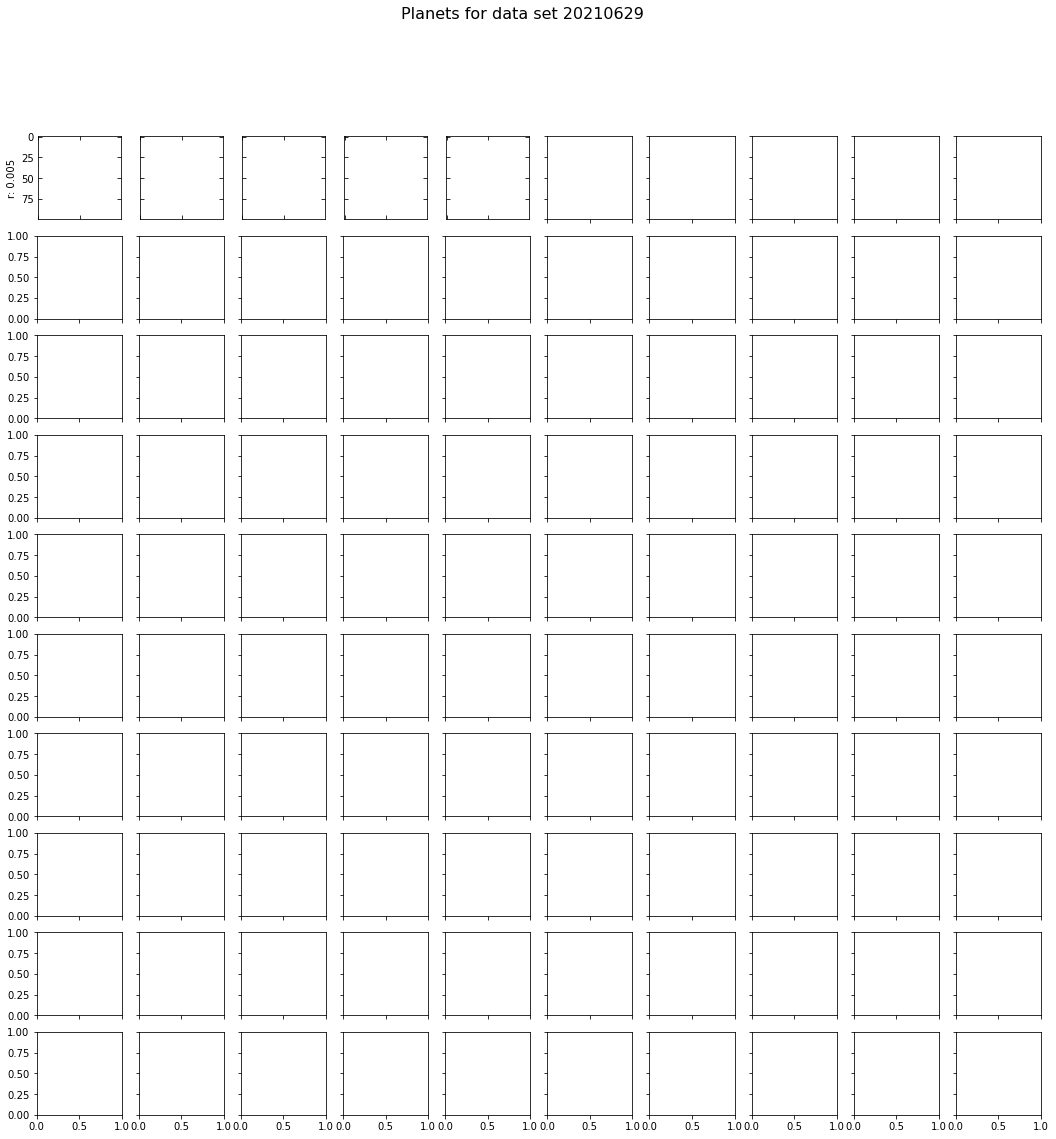

In [7]:
times = getTimes("tesslc_364539361")

fig, axs = plt.subplots(10,10,figsize = (18,18))

for i in range(1):
    for j in range(5):
        points = generatePoints(0,0.005*(i)+0.01,100,50,50)
        pointsList = []
        pointsList.append(points)
        planetGrid = fillShape(np.zeros([100,100]),pointsList)
        filename ="Signals/r00v"+str(2**j)+".txt"
        export(planetGrid, times, filename, 2**j)
        axs[i][j].imshow(planetGrid, cmap = "Greys",aspect = 'equal', origin = 'upper')
        axs[i][j].tick_params(direction = "in", which = "major", length = 4, top = True, right = True)
        axs[i][j].tick_params(direction = "in", which = "minor", length = 2, top = True, right = True)
        axs[i][j].set_ylabel("r: "+str(0.001*(i)+0.005))
        axs[i][j].set_xlabel("v: "+str(2**j))
        for ax in axs.flat:
            ax.label_outer()
            
fig.suptitle("Planets for data set 20210629", fontsize = 16)
#fig.savefig("DataVisualization/20210629/planets.png")
plt.show()

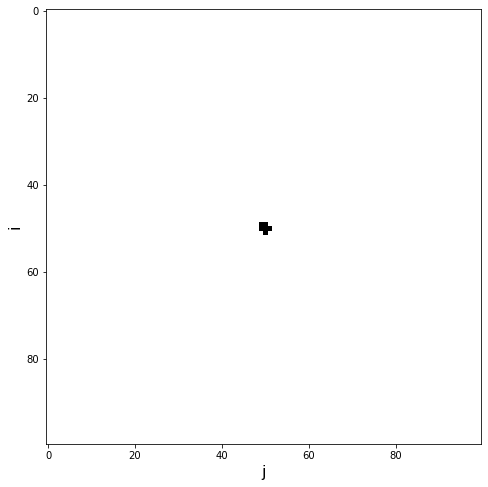

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


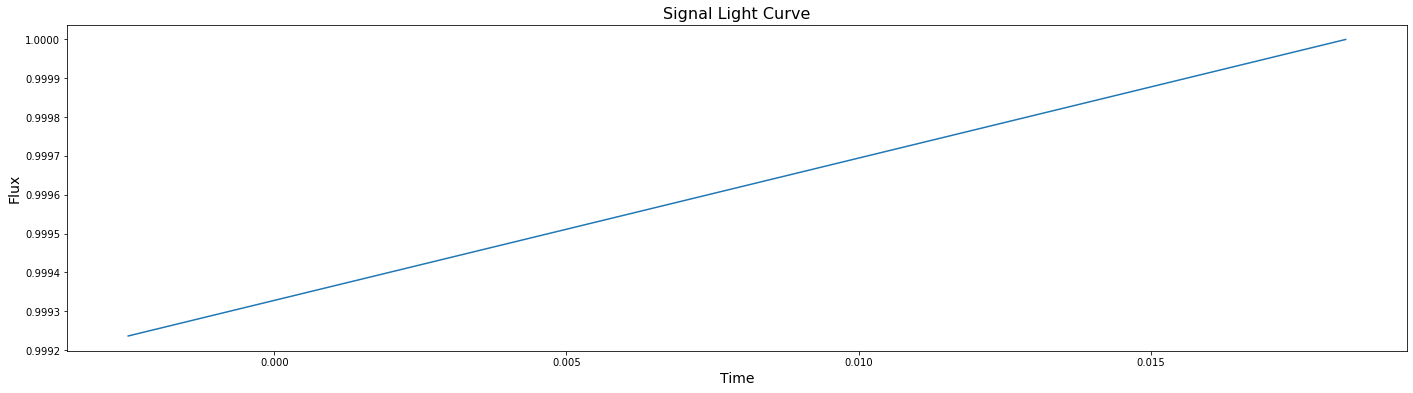

'\nfor q in range(5):\n    for m in range(5):\n        for i in range(5): \n            fig, axs = plt.subplots(5,5,figsize = (24,12))\n            for j in range(5):\n                for l in range(5):\n                    if i == 0:\n                        n = 20\n                    else:\n                        n = i+2\n                    prop = 0.4096 * 1.5625**j\n                    velocity = 2**(q)\n                    points = generatePoints(n,(m+1)*0.01,100,50,50,(l)*np.pi/4,prop,np.pi/(n))\n                    planetGrid = fillShape(np.zeros([100,100]),[points])\n                    filename = "Signals/n"+str(i+3)+"t"+str((l)*180/4)+"k"+str(prop)+"r"+str((m+1)*0.01)+"v"+str(velocity)+".txt"\n                    export(planetGrid, times, filename, velocity)\n                    if q == 0:\n                        axs[l][j].imshow(planetGrid, cmap = "Greys",aspect = \'equal\', origin = \'upper\')\n                        axs[l][j].tick_params(direction = "in", which = "majo

In [13]:
times = getTimes("tesslc_364539361")

points = generatePoints(20,0.01,100,50,50)
pointsList = []
pointsList.append(points)
planetGrid = fillShape(np.zeros([100,100]),pointsList)
planet = TransitingImage(opacitymat = planetGrid, v = 100, t_ref = 0, t_arr = times)
planet.plot_grid()
planetLC, overlapTimes = planet.gen_LC(t_arr = times)

fig, ax = plt.subplots(1,1,figsize=(24,6))##Plotting for good measure
ax.plot(overlapTimes,planetLC)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Flux",fontsize=14)
plt.title(r"Signal Light Curve",fontsize=16)
plt.show()



'''
for q in range(5):
    for m in range(5):
        for i in range(5): 
            fig, axs = plt.subplots(5,5,figsize = (24,12))
            for j in range(5):
                for l in range(5):
                    if i == 0:
                        n = 20
                    else:
                        n = i+2
                    prop = 0.4096 * 1.5625**j
                    velocity = 2**(q)
                    points = generatePoints(n,(m+1)*0.01,100,50,50,(l)*np.pi/4,prop,np.pi/(n))
                    planetGrid = fillShape(np.zeros([100,100]),[points])
                    filename = "Signals/n"+str(i+3)+"t"+str((l)*180/4)+"k"+str(prop)+"r"+str((m+1)*0.01)+"v"+str(velocity)+".txt"
                    export(planetGrid, times, filename, velocity)
                    if q == 0:
                        axs[l][j].imshow(planetGrid, cmap = "Greys",aspect = 'equal', origin = 'upper')
                        axs[l][j].tick_params(direction = "in", which = "major", length = 4, top = True, right = True)
                        axs[l][j].tick_params(direction = "in", which = "minor", length = 2, top = True, right = True)
                        axs[l][j].set_xlabel("k: "+ str(prop))
                        axs[l][j].set_ylabel("t: "+str((l)*180/4))
                        for ax in axs.flat:
                            ax.label_outer()
            if q == 0:
                fig.suptitle("Planets for dataset 20210610, n: "+str(n) + "r: "+str((m+1)*0.01), fontsize = 16)           
                fig.savefig("DataVisualization/20210622/n"+str(n)+"r"+str((m+1))+"planet.png")
                plt.show()
 
'''    